<a href="https://colab.research.google.com/github/santiagonajera/Ventas-Diarias/blob/main/conProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data(url):
    """Cargar y preparar los datos"""
    # Cargar datos desde GitHub (usando el raw URL)
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob', '')
    df = pd.read_csv(raw_url)

    # Convertir la columna de fecha a datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Ordenar por fecha
    df = df.sort_values('Fecha').reset_index(drop=True)

    return df

def aggregate_to_monthly(df):
    """Convertir datos diarios a mensuales"""
    # Agrupar por mes y sumar las ventas
    df_monthly = df.groupby(df['Fecha'].dt.to_period('M')).agg({
        'Pizza': 'sum',
        'Hamburguesa': 'sum',
        'Ensalada': 'sum',
        'Sushi': 'sum'
    }).reset_index()

    # Convertir el período a fecha (primer día del mes)
    df_monthly['Fecha'] = df_monthly['Fecha'].dt.to_timestamp()

    return df_monthly

def analyze_seasonality_and_trend(df_monthly, product):
    """Analizar estacionalidad y tendencia para un producto"""
    # Crear serie temporal
    ts = df_monthly.set_index('Fecha')[product]

    # Descomposición de la serie temporal
    decomposition = seasonal_decompose(ts, model='additive', period=12)

    return decomposition

def forecast_next_3_months(df_monthly, product):
    """Generar forecast para los próximos 3 meses"""
    # Crear serie temporal
    ts = df_monthly.set_index('Fecha')[product]

    # Modelo de suavizamiento exponencial con tendencia y estacionalidad
    model = ExponentialSmoothing(
        ts,
        trend='add',
        seasonal='add',
        seasonal_periods=12,
        initialization_method='estimated'
    )

    # Ajustar el modelo
    fitted_model = model.fit()

    # Forecast para los próximos 3 meses
    forecast = fitted_model.forecast(steps=3)

    # Intervalos de confianza
    forecast_ci = fitted_model.conf_int(alpha=0.05)
    forecast_ci_next = forecast_ci.iloc[-3:]

    return forecast, forecast_ci_next, fitted_model

def create_forecast_dates(last_date, periods=3):
    """Crear fechas para el forecast"""
    forecast_dates = []
    current_date = last_date

    for i in range(periods):
        # Agregar un mes
        if current_date.month == 12:
            next_date = current_date.replace(year=current_date.year + 1, month=1, day=1)
        else:
            next_date = current_date.replace(month=current_date.month + 1, day=1)
        forecast_dates.append(next_date)
        current_date = next_date

    return forecast_dates

def plot_forecast_results(df_monthly, product, forecast, forecast_dates, decomposition):
    """Crear gráficas de los resultados"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análisis y Forecasting - {product}', fontsize=16, fontweight='bold')

    # 1. Serie original con forecast
    axes[0, 0].plot(df_monthly['Fecha'], df_monthly[product], marker='o', linewidth=2, label='Datos históricos')
    axes[0, 0].plot(forecast_dates, forecast, marker='s', linewidth=2, color='red', label='Forecast')
    axes[0, 0].set_title('Ventas Históricas y Forecast')
    axes[0, 0].set_xlabel('Fecha')
    axes[0, 0].set_ylabel('Ventas')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Tendencia
    axes[0, 1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='orange')
    axes[0, 1].set_title('Tendencia')
    axes[0, 1].set_xlabel('Fecha')
    axes[0, 1].set_ylabel('Tendencia')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Estacionalidad
    axes[1, 0].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='green')
    axes[1, 0].set_title('Componente Estacional')
    axes[1, 0].set_xlabel('Fecha')
    axes[1, 0].set_ylabel('Estacionalidad')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Residuos
    axes[1, 1].plot(decomposition.resid.index, decomposition.resid.values, marker='o', linewidth=1, color='purple')
    axes[1, 1].set_title('Residuos')
    axes[1, 1].set_xlabel('Fecha')
    axes[1, 1].set_ylabel('Residuos')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def main():
    # URL del archivo
    url = "https://github.com/santiagonajera/Ventas-Diarias/blob/main/Ventas_diarias_restaurante.csv"

    try:
        # Cargar y preparar datos
        print("Cargando datos...")
        df = load_and_prepare_data(url)
        print(f"Datos cargados: {len(df)} registros")

        # Convertir a datos mensuales
        print("Agregando datos a nivel mensual...")
        df_monthly = aggregate_to_monthly(df)
        print(f"Datos mensuales: {len(df_monthly)} meses")

        # Productos a analizar
        products = ['Pizza', 'Hamburguesa', 'Ensalada', 'Sushi']

        # Diccionario para almacenar resultados
        forecast_results = {}

        # Procesar cada producto
        for product in products:
            print(f"\nAnalizando {product}...")

            # Análisis de estacionalidad y tendencia
            decomposition = analyze_seasonality_and_trend(df_monthly, product)

            # Forecast para los próximos 3 meses
            forecast, forecast_ci, model = forecast_next_3_months(df_monthly, product)

            # Crear fechas para el forecast
            last_date = df_monthly['Fecha'].iloc[-1]
            forecast_dates = create_forecast_dates(last_date)

            # Almacenar resultados
            forecast_results[product] = {
                'forecast': forecast,
                'forecast_dates': forecast_dates,
                'confidence_intervals': forecast_ci,
                'decomposition': decomposition,
                'model': model
            }

            # Mostrar resultados numéricos
            print(f"Forecast para {product} (próximos 3 meses):")
            for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
                print(f"  {date.strftime('%Y-%m')}: {value:.1f}")

            # Crear gráficas
            plot_forecast_results(df_monthly, product, forecast, forecast_dates, decomposition)

        # Crear resumen de forecasts
        print("\n" + "="*60)
        print("RESUMEN DE FORECASTS - PRÓXIMOS 3 MESES")
        print("="*60)

        # Crear DataFrame con todos los forecasts
        summary_data = []
        for product in products:
            forecast = forecast_results[product]['forecast']
            forecast_dates = forecast_results[product]['forecast_dates']

            for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
                summary_data.append({
                    'Producto': product,
                    'Mes': date.strftime('%Y-%m'),
                    'Forecast': round(value, 1)
                })

        summary_df = pd.DataFrame(summary_data)
        summary_pivot = summary_df.pivot(index='Mes', columns='Producto', values='Forecast')
        print(summary_pivot)

        # Guardar resultados en CSV
        summary_df.to_csv('forecast_resultados.csv', index=False)
        print(f"\nResultados guardados en 'forecast_resultados.csv'")

        # Mostrar estadísticas descriptivas
        print("\n" + "="*60)
        print("ESTADÍSTICAS DESCRIPTIVAS - DATOS MENSUALES")
        print("="*60)
        monthly_stats = df_monthly[products].describe()
        print(monthly_stats.round(2))

    except Exception as e:
        print(f"Error: {str(e)}")
        print("Asegúrate de tener conexión a internet y que el archivo esté disponible en la URL proporcionada.")

if __name__ == "__main__":
    main()

Cargando datos...
Datos cargados: 731 registros
Agregando datos a nivel mensual...
Datos mensuales: 24 meses

Analizando Pizza...
Error: 'HoltWintersResults' object has no attribute 'conf_int'
Asegúrate de tener conexión a internet y que el archivo esté disponible en la URL proporcionada.


Cargando datos desde GitHub...
Datos cargados: 731 registros
Agregando datos a nivel mensual...
Datos mensuales: 24 meses

Analizando Pizza...
Forecast para Pizza (próximos 3 meses):
  2025-01: 2217.7
  2025-02: 1912.3
  2025-03: 1876.7


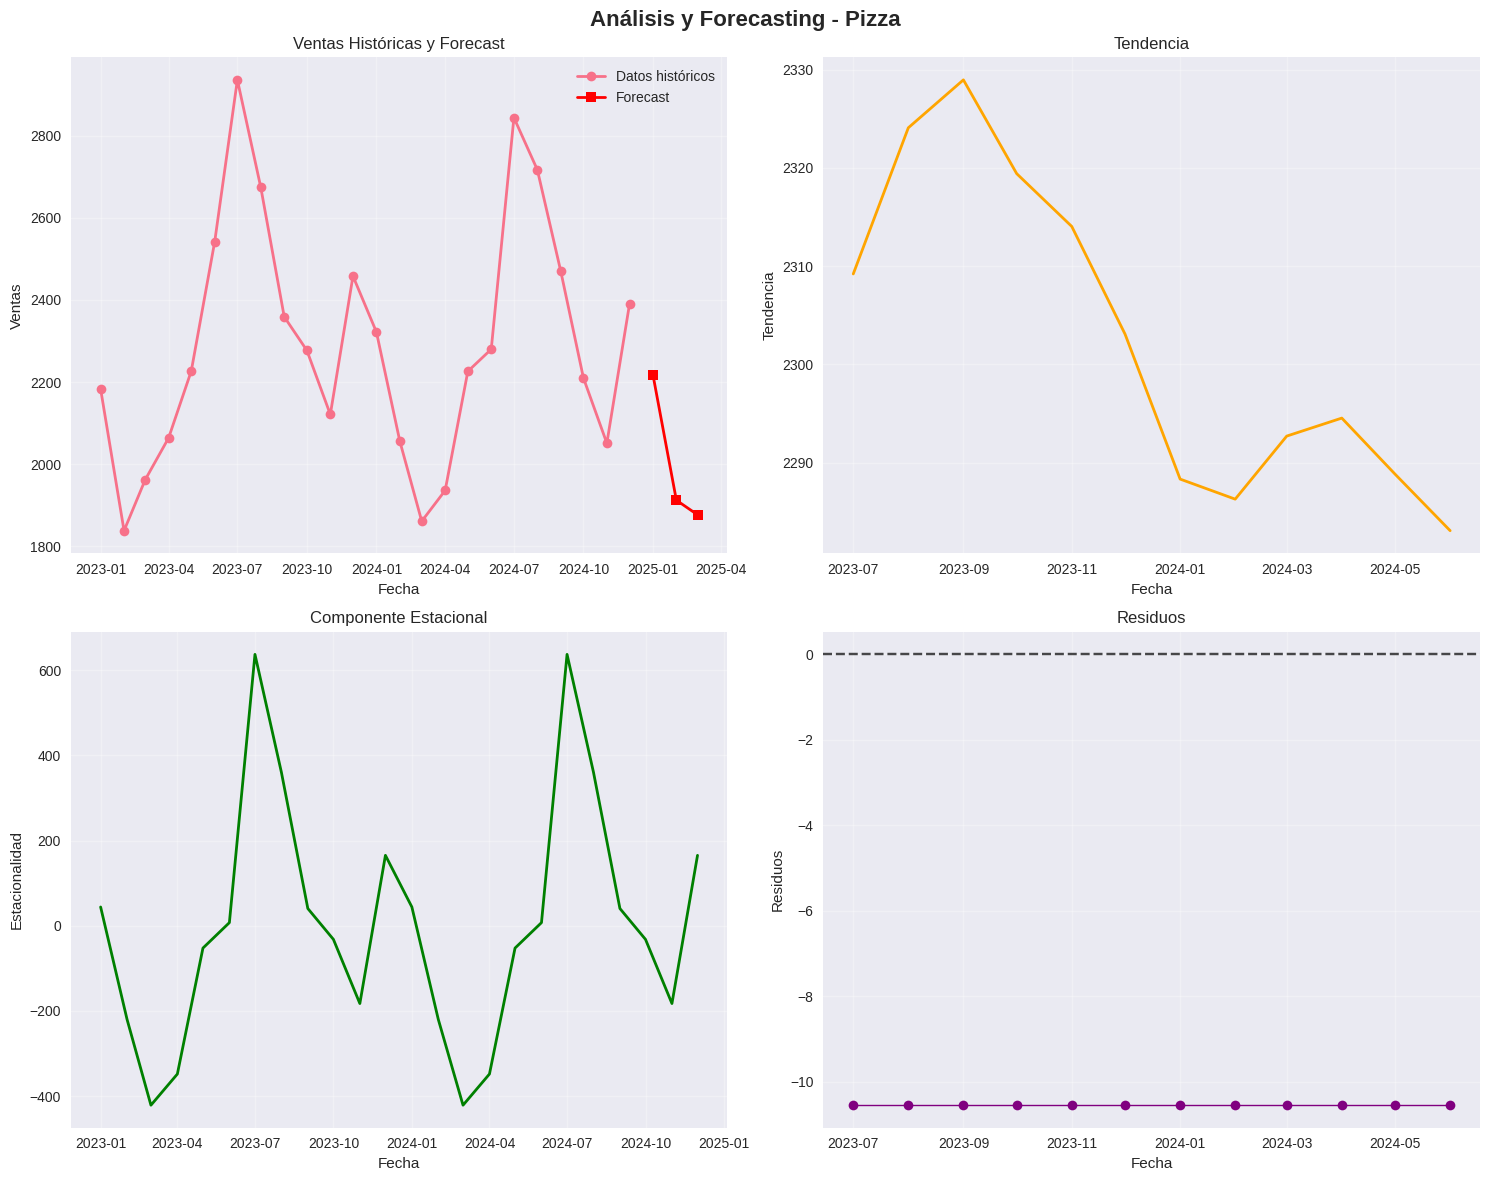


Analizando Hamburguesa...
Forecast para Hamburguesa (próximos 3 meses):
  2025-01: 1775.5
  2025-02: 1569.0
  2025-03: 1640.5


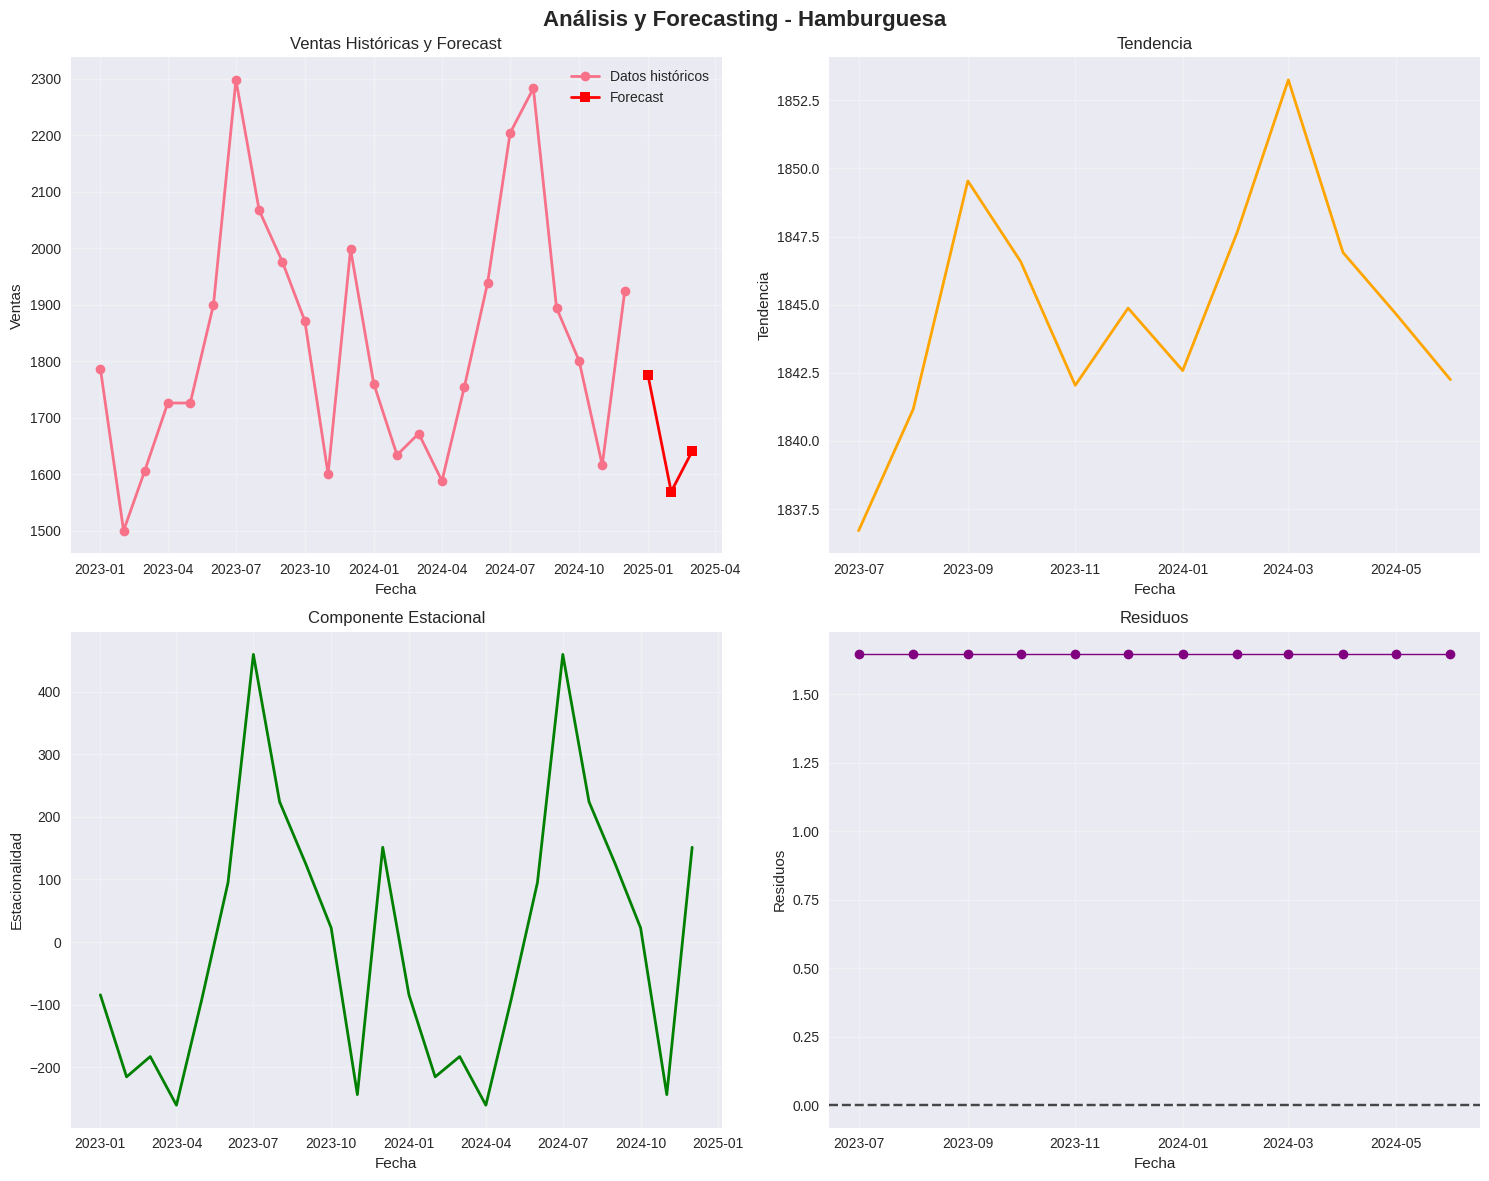


Analizando Ensalada...
Forecast para Ensalada (próximos 3 meses):
  2025-01: 1074.9
  2025-02: 893.9
  2025-03: 863.4


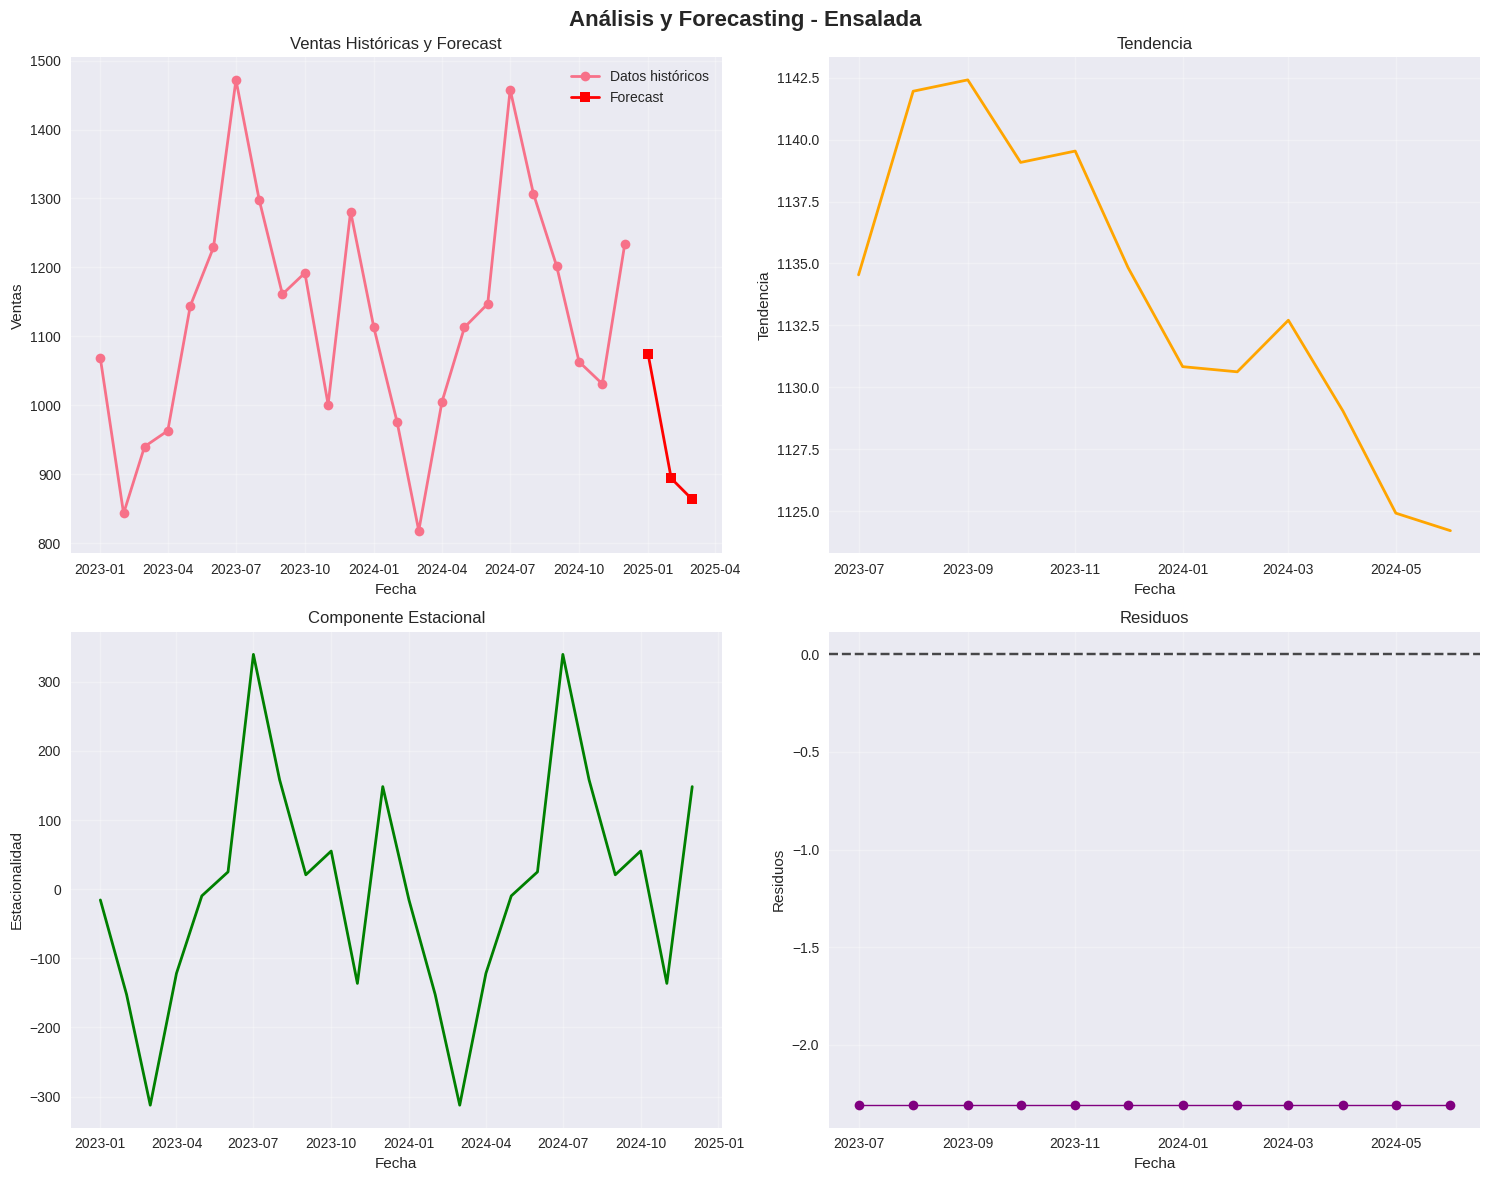


Analizando Sushi...
Forecast para Sushi (próximos 3 meses):
  2025-01: 1450.1
  2025-02: 1258.1
  2025-03: 1180.1


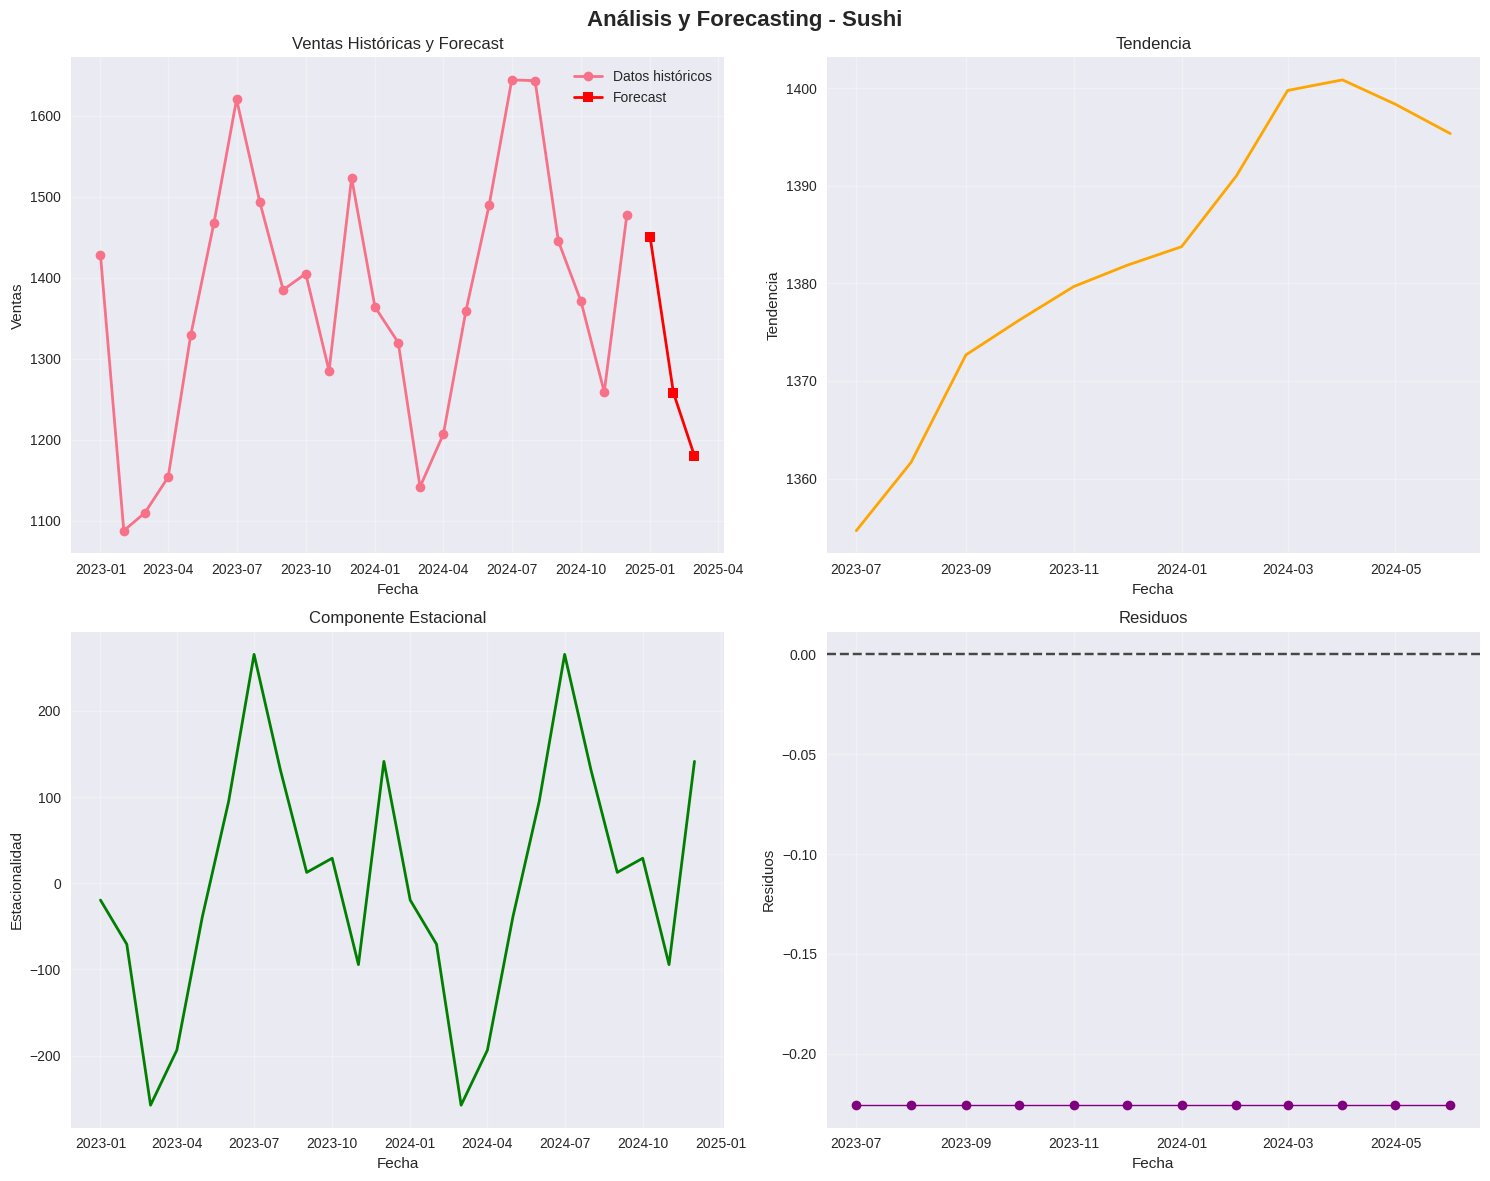


RESUMEN DE FORECASTS - PRÓXIMOS 3 MESES
Producto  Ensalada  Hamburguesa   Pizza   Sushi
Mes                                            
2025-01     1074.9       1775.5  2217.7  1450.1
2025-02      893.9       1569.0  1912.3  1258.1
2025-03      863.4       1640.5  1876.7  1180.1

Resultados guardados en 'forecast_resultados.csv'

ESTADÍSTICAS DESCRIPTIVAS - DATOS MENSUALES
         Pizza  Hamburguesa  Ensalada    Sushi
count    24.00        24.00     24.00    24.00
mean   2291.83      1838.50   1127.46  1375.38
std     297.29       220.13    168.91   160.44
min    1838.00      1500.00    818.00  1088.00
25%    2062.00      1662.50   1004.00  1278.50
50%    2252.00      1794.00   1128.50  1378.00
75%    2461.00      1948.25   1230.25  1480.25
max    2936.00      2298.00   1472.00  1644.00


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data(url):
    """Cargar y preparar los datos desde GitHub"""
    # Convertir URL de GitHub a URL raw
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob', '')

    # Cargar datos
    df = pd.read_csv(raw_url)

    # Convertir la columna de fecha a datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Ordenar por fecha
    df = df.sort_values('Fecha').reset_index(drop=True)

    return df

def aggregate_to_monthly(df):
    """Convertir datos diarios a mensuales"""
    # Agrupar por mes y sumar las ventas
    df_monthly = df.groupby(df['Fecha'].dt.to_period('M')).agg({
        'Pizza': 'sum',
        'Hamburguesa': 'sum',
        'Ensalada': 'sum',
        'Sushi': 'sum'
    }).reset_index()

    # Convertir el período a fecha (primer día del mes)
    df_monthly['Fecha'] = df_monthly['Fecha'].dt.to_timestamp()

    return df_monthly

def analyze_seasonality_and_trend(df_monthly, product):
    """Analizar estacionalidad y tendencia para un producto"""
    # Crear serie temporal
    ts = df_monthly.set_index('Fecha')[product]

    # Descomposición de la serie temporal
    decomposition = seasonal_decompose(ts, model='additive', period=12)

    return decomposition

def forecast_next_3_months(df_monthly, product):
    """Generar forecast para los próximos 3 meses"""
    # Crear serie temporal
    ts = df_monthly.set_index('Fecha')[product]

    # Modelo de suavizamiento exponencial con tendencia y estacionalidad
    model = ExponentialSmoothing(
        ts,
        trend='add',
        seasonal='add',
        seasonal_periods=12,
        initialization_method='estimated'
    )

    # Ajustar el modelo
    fitted_model = model.fit()

    # Forecast para los próximos 3 meses
    forecast = fitted_model.forecast(steps=3)

    return forecast, fitted_model

def create_forecast_dates(last_date, periods=3):
    """Crear fechas para el forecast"""
    forecast_dates = []
    current_date = last_date

    for i in range(periods):
        # Agregar un mes
        if current_date.month == 12:
            next_date = current_date.replace(year=current_date.year + 1, month=1, day=1)
        else:
            next_date = current_date.replace(month=current_date.month + 1, day=1)
        forecast_dates.append(next_date)
        current_date = next_date

    return forecast_dates

def plot_forecast_results(df_monthly, product, forecast, forecast_dates, decomposition):
    """Crear gráficas de los resultados"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análisis y Forecasting - {product}', fontsize=16, fontweight='bold')

    # 1. Serie original con forecast
    axes[0, 0].plot(df_monthly['Fecha'], df_monthly[product], marker='o', linewidth=2, label='Datos históricos')
    axes[0, 0].plot(forecast_dates, forecast, marker='s', linewidth=2, color='red', label='Forecast')
    axes[0, 0].set_title('Ventas Históricas y Forecast')
    axes[0, 0].set_xlabel('Fecha')
    axes[0, 0].set_ylabel('Ventas')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Tendencia
    axes[0, 1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='orange')
    axes[0, 1].set_title('Tendencia')
    axes[0, 1].set_xlabel('Fecha')
    axes[0, 1].set_ylabel('Tendencia')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Estacionalidad
    axes[1, 0].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='green')
    axes[1, 0].set_title('Componente Estacional')
    axes[1, 0].set_xlabel('Fecha')
    axes[1, 0].set_ylabel('Estacionalidad')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Residuos
    axes[1, 1].plot(decomposition.resid.index, decomposition.resid.values, marker='o', linewidth=1, color='purple')
    axes[1, 1].set_title('Residuos')
    axes[1, 1].set_xlabel('Fecha')
    axes[1, 1].set_ylabel('Residuos')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def main():
    # URL del archivo en GitHub
    url = "https://github.com/santiagonajera/Ventas-Diarias/blob/main/Ventas_diarias_restaurante.csv"

    try:
        # Cargar y preparar datos
        print("Cargando datos desde GitHub...")
        df = load_and_prepare_data(url)
        print(f"Datos cargados: {len(df)} registros")

        # Convertir a datos mensuales
        print("Agregando datos a nivel mensual...")
        df_monthly = aggregate_to_monthly(df)
        print(f"Datos mensuales: {len(df_monthly)} meses")

        # Productos a analizar
        products = ['Pizza', 'Hamburguesa', 'Ensalada', 'Sushi']

        # Diccionario para almacenar resultados
        forecast_results = {}

        # Procesar cada producto
        for product in products:
            print(f"\nAnalizando {product}...")

            # Análisis de estacionalidad y tendencia
            decomposition = analyze_seasonality_and_trend(df_monthly, product)

            # Forecast para los próximos 3 meses
            forecast, model = forecast_next_3_months(df_monthly, product)

            # Crear fechas para el forecast
            last_date = df_monthly['Fecha'].iloc[-1]
            forecast_dates = create_forecast_dates(last_date)

            # Almacenar resultados
            forecast_results[product] = {
                'forecast': forecast,
                'forecast_dates': forecast_dates,
                'decomposition': decomposition,
                'model': model
            }

            # Mostrar resultados numéricos
            print(f"Forecast para {product} (próximos 3 meses):")
            for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
                print(f"  {date.strftime('%Y-%m')}: {value:.1f}")

            # Crear gráficas
            plot_forecast_results(df_monthly, product, forecast, forecast_dates, decomposition)

        # Crear resumen de forecasts
        print("\n" + "="*60)
        print("RESUMEN DE FORECASTS - PRÓXIMOS 3 MESES")
        print("="*60)

        # Crear DataFrame con todos los forecasts
        summary_data = []
        for product in products:
            forecast = forecast_results[product]['forecast']
            forecast_dates = forecast_results[product]['forecast_dates']

            for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
                summary_data.append({
                    'Producto': product,
                    'Mes': date.strftime('%Y-%m'),
                    'Forecast': round(value, 1)
                })

        summary_df = pd.DataFrame(summary_data)
        summary_pivot = summary_df.pivot(index='Mes', columns='Producto', values='Forecast')
        print(summary_pivot)

        # Guardar resultados en CSV
        summary_df.to_csv('forecast_resultados.csv', index=False)
        print(f"\nResultados guardados en 'forecast_resultados.csv'")

        # Mostrar estadísticas descriptivas
        print("\n" + "="*60)
        print("ESTADÍSTICAS DESCRIPTIVAS - DATOS MENSUALES")
        print("="*60)
        monthly_stats = df_monthly[products].describe()
        print(monthly_stats.round(2))

    except Exception as e:
        print(f"Error: {str(e)}")
        print("Asegúrate de tener conexión a internet y que el archivo esté disponible en la URL proporcionada.")

if __name__ == "__main__":
    main()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Intentar importar Prophet, si no está instalada, instalarla
try:
    from prophet import Prophet
    print("Prophet ya está instalada")
except ImportError:
    print("Instalando Prophet...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "prophet"])
    from prophet import Prophet
    print("Prophet instalada correctamente")

# Configuración de estilo para las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data():
    """Cargar y preparar los datos desde el archivo local"""
    # Cargar datos
    df = pd.read_csv('Ventas_diarias_restaurante.csv')

    # Convertir la columna de fecha a datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Ordenar por fecha
    df = df.sort_values('Fecha').reset_index(drop=True)

    return df

def prepare_data_for_prophet(df, product):
    """Preparar datos para Prophet"""
    # Seleccionar solo las columnas necesarias
    data = df[['Fecha', product]].copy()

    # Renombrar columnas según lo requerido por Prophet
    data = data.rename(columns={'Fecha': 'ds', product: 'y'})

    return data

def forecast_next_15_days(df_prophet, product_name):
    """Generar forecast para los próximos 15 días usando Prophet"""

    # Crear y configurar el modelo Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive'
    )

    # Ajustar el modelo
    model.fit(df_prophet)

    # Crear dataframe para future predictions (próximos 15 días)
    future = model.make_future_dataframe(periods=15)

    # Hacer las predicciones
    forecast = model.predict(future)

    return model, forecast

def plot_prophet_forecast(model, forecast, product_name, df_prophet):
    """Crear gráfica de forecast de Prophet"""
    fig = model.plot(forecast, figsize=(12, 6))
    plt.title(f'Forecast de {product_name} - Próximos 15 días', fontsize=14, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Gráfica de componentes
    fig2 = model.plot_components(forecast, figsize=(12, 8))
    plt.show()

def main():
    try:
        # Cargar y preparar datos
        print("Cargando datos...")
        df = load_and_prepare_data()
        print(f"Datos cargados: {len(df)} registros")
        print(f"Rango de fechas: {df['Fecha'].min()} a {df['Fecha'].max()}")

        # Productos a analizar
        products = ['Pizza', 'Hamburguesa', 'Ensalada', 'Sushi']

        # Diccionario para almacenar resultados
        forecast_results = {}

        # Procesar cada producto
        for product in products:
            print(f"\nAnalizando {product}...")

            # Preparar datos para Prophet
            df_prophet = prepare_data_for_prophet(df, product)

            # Forecast para los próximos 15 días
            model, forecast = forecast_next_15_days(df_prophet, product)

            # Almacenar resultados
            forecast_results[product] = {
                'model': model,
                'forecast': forecast,
                'df_prophet': df_prophet
            }

            # Mostrar resultados numéricos para los próximos 15 días
            print(f"Forecast para {product} (próximos 15 días):")
            future_forecast = forecast.tail(15)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
            future_forecast['ds'] = pd.to_datetime(future_forecast['ds'])
            future_forecast = future_forecast.round(1)

            for idx, row in future_forecast.iterrows():
                print(f"  {row['ds'].strftime('%Y-%m-%d')}: {row['yhat']:.1f} "
                      f"(IC: {row['yhat_lower']:.1f} - {row['yhat_upper']:.1f})")

            # Crear gráficas
            plot_prophet_forecast(model, forecast, product, df_prophet)

        # Crear resumen de forecasts
        print("\n" + "="*80)
        print("RESUMEN DE FORECASTS - PRÓXIMOS 15 DÍAS")
        print("="*80)

        # Crear DataFrame con todos los forecasts futuros
        summary_data = []
        for product in products:
            forecast = forecast_results[product]['forecast']
            future_forecast = forecast.tail(15)[['ds', 'yhat']].copy()
            future_forecast['Producto'] = product
            future_forecast = future_forecast.rename(columns={'ds': 'Fecha', 'yhat': 'Forecast'})
            summary_data.append(future_forecast)

        # Combinar todos los resultados
        summary_df = pd.concat(summary_data, ignore_index=True)
        summary_pivot = summary_df.pivot(index='Fecha', columns='Producto', values='Forecast')
        summary_pivot = summary_pivot.round(1)
        print(summary_pivot)

        # Guardar resultados en CSV
        summary_df.to_csv('forecast_15_dias_resultados.csv', index=False)
        print(f"\nResultados guardados en 'forecast_15_dias_resultados.csv'")

        # Mostrar estadísticas descriptivas
        print("\n" + "="*60)
        print("ESTADÍSTICAS DESCRIPTIVAS - DATOS DIARIOS")
        print("="*60)
        daily_stats = df[products].describe()
        print(daily_stats.round(2))

    except Exception as e:
        print(f"Error: {str(e)}")
        print("Asegúrate de que el archivo 'Ventas_diarias_restaurante.csv' esté en el directorio correcto.")

if __name__ == "__main__":
    main()

Prophet ya está instalada
Cargando datos...
Error: [Errno 2] No such file or directory: 'Ventas_diarias_restaurante.csv'
Asegúrate de que el archivo 'Ventas_diarias_restaurante.csv' esté en el directorio correcto.


Prophet ya está instalada
Cargando datos desde GitHub...
Datos cargados: 731 registros
Rango de fechas: 2023-01-01 00:00:00 a 2024-12-31 00:00:00

Analizando Pizza...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxo9zbf2x/zlr_j7gm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxo9zbf2x/2_h3omwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85896', 'data', 'file=/tmp/tmpxo9zbf2x/zlr_j7gm.json', 'init=/tmp/tmpxo9zbf2x/2_h3omwk.json', 'output', 'file=/tmp/tmpxo9zbf2x/prophet_modeln6nfjy4u/prophet_model-20250726165502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:55:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast para Pizza (próximos 15 días):
  2025-01-01: 69.8 (IC: 51.4 - 88.9)
  2025-01-02: 74.0 (IC: 53.6 - 93.1)
  2025-01-03: 83.8 (IC: 65.0 - 103.5)
  2025-01-04: 93.8 (IC: 73.6 - 111.9)
  2025-01-05: 87.7 (IC: 69.5 - 106.9)
  2025-01-06: 63.4 (IC: 45.2 - 82.8)
  2025-01-07: 66.3 (IC: 47.2 - 84.9)
  2025-01-08: 66.9 (IC: 46.3 - 85.4)
  2025-01-09: 71.0 (IC: 52.0 - 90.2)
  2025-01-10: 80.5 (IC: 61.6 - 98.5)
  2025-01-11: 90.4 (IC: 70.9 - 111.4)
  2025-01-12: 84.2 (IC: 63.8 - 102.7)
  2025-01-13: 59.8 (IC: 40.1 - 79.5)
  2025-01-14: 62.6 (IC: 44.0 - 81.4)
  2025-01-15: 63.2 (IC: 43.9 - 80.6)


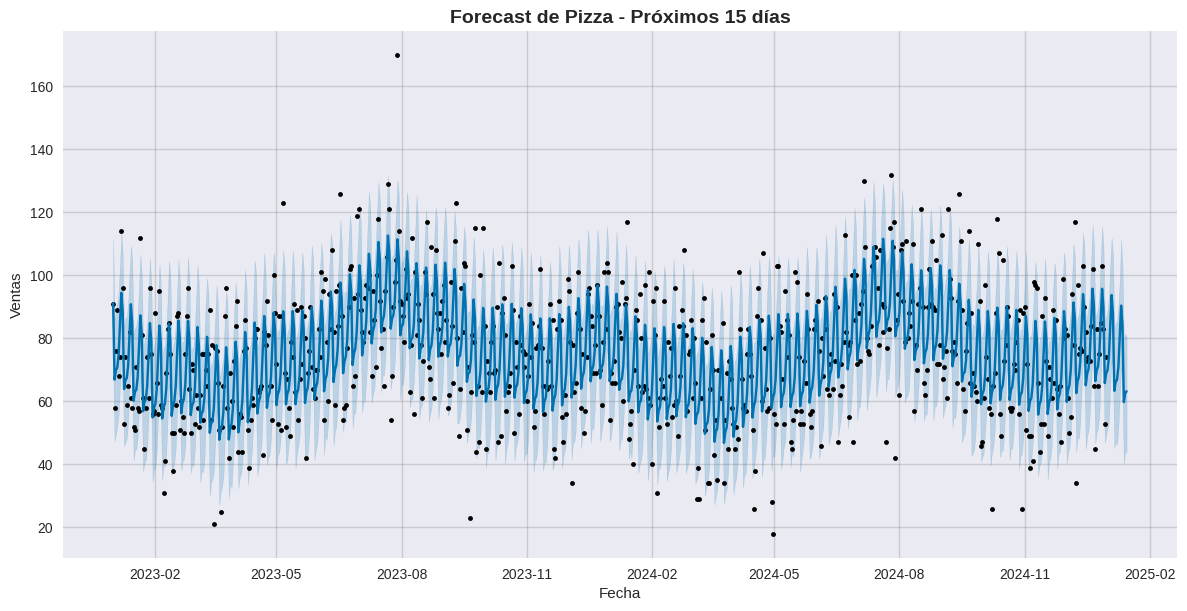

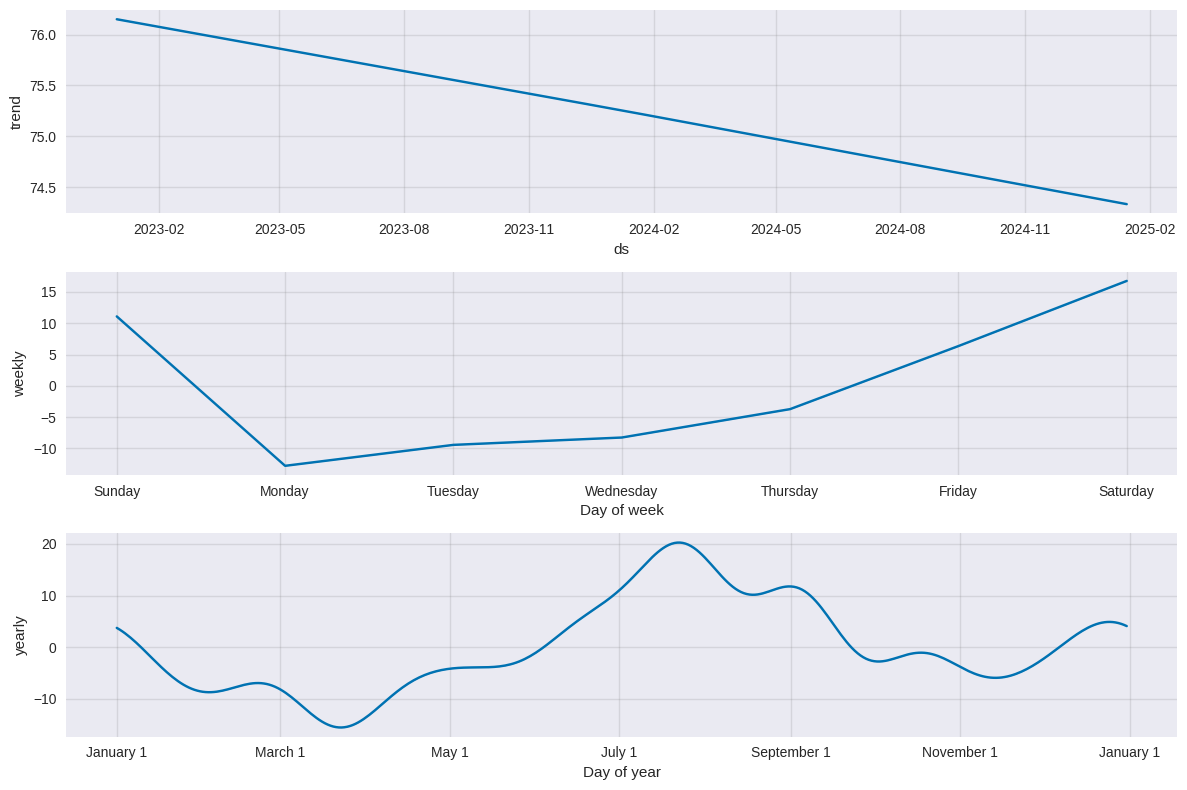

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxo9zbf2x/gjg12cz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxo9zbf2x/1fdnu4oe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81608', 'data', 'file=/tmp/tmpxo9zbf2x/gjg12cz6.json', 'init=/tmp/tmpxo9zbf2x/1fdnu4oe.json', 'output', 'file=/tmp/tmpxo9zbf2x/prophet_modelj2quep0a/prophet_model-20250726165504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:55:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:55:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Analizando Hamburguesa...
Forecast para Hamburguesa (próximos 15 días):
  2025-01-01: 50.0 (IC: 35.2 - 65.5)
  2025-01-02: 55.5 (IC: 39.0 - 70.6)
  2025-01-03: 60.3 (IC: 44.9 - 77.1)
  2025-01-04: 71.5 (IC: 55.3 - 86.7)
  2025-01-05: 67.1 (IC: 52.0 - 83.3)
  2025-01-06: 46.3 (IC: 31.0 - 61.3)
  2025-01-07: 51.4 (IC: 36.8 - 66.8)
  2025-01-08: 51.3 (IC: 35.0 - 67.2)
  2025-01-09: 57.0 (IC: 40.8 - 73.0)
  2025-01-10: 62.0 (IC: 46.2 - 77.6)
  2025-01-11: 73.2 (IC: 57.2 - 87.4)
  2025-01-12: 68.8 (IC: 53.9 - 83.3)
  2025-01-13: 47.9 (IC: 31.7 - 64.2)
  2025-01-14: 52.9 (IC: 36.7 - 67.6)
  2025-01-15: 52.6 (IC: 35.8 - 68.9)


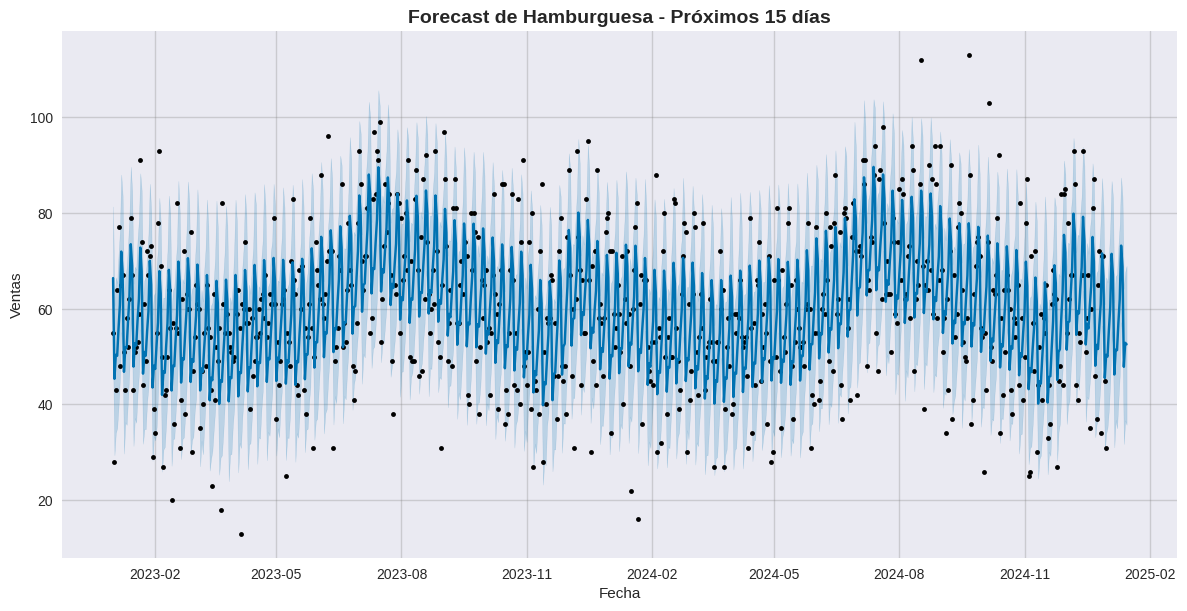

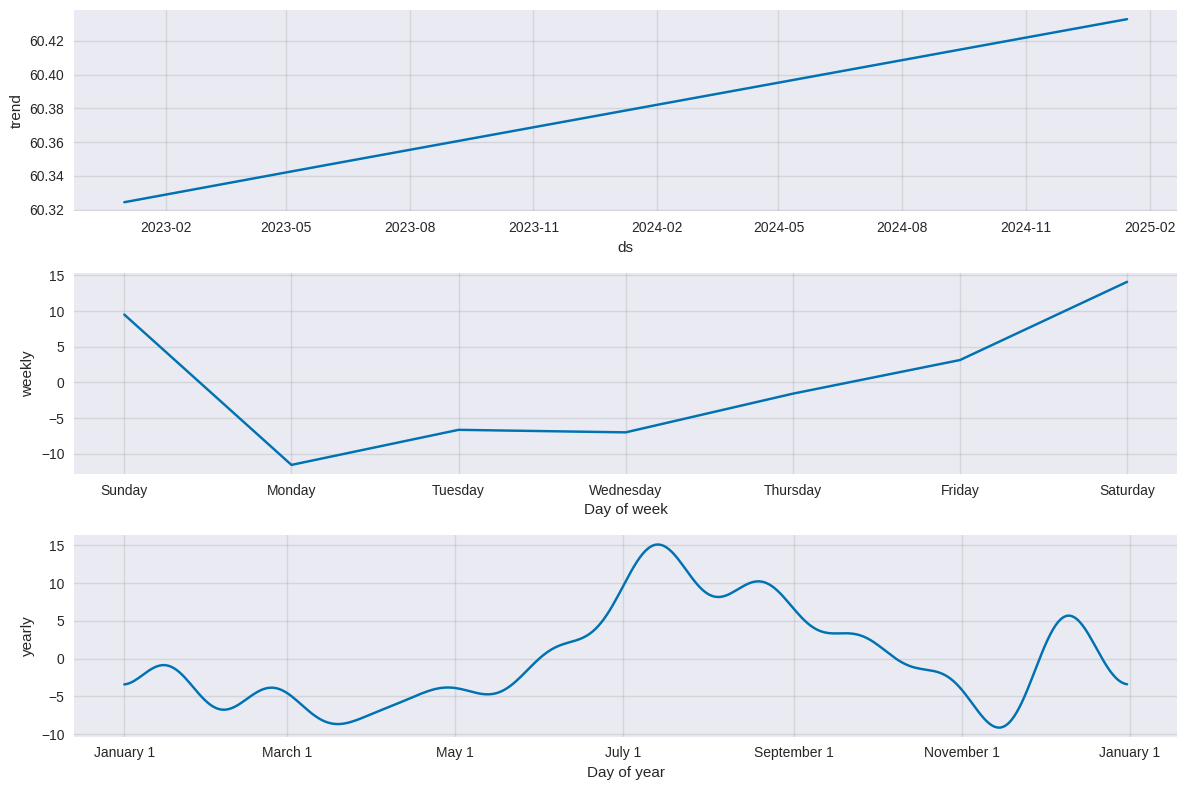

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxo9zbf2x/yvy_jge9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxo9zbf2x/ya18by42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14505', 'data', 'file=/tmp/tmpxo9zbf2x/yvy_jge9.json', 'init=/tmp/tmpxo9zbf2x/ya18by42.json', 'output', 'file=/tmp/tmpxo9zbf2x/prophet_modeldsf3ljvd/prophet_model-20250726165505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:55:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Analizando Ensalada...


16:55:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast para Ensalada (próximos 15 días):
  2025-01-01: 33.1 (IC: 23.2 - 43.8)
  2025-01-02: 36.7 (IC: 26.5 - 46.4)
  2025-01-03: 37.3 (IC: 27.6 - 47.1)
  2025-01-04: 44.7 (IC: 35.1 - 54.6)
  2025-01-05: 41.3 (IC: 31.3 - 51.6)
  2025-01-06: 30.5 (IC: 21.0 - 39.9)
  2025-01-07: 31.6 (IC: 22.2 - 41.8)
  2025-01-08: 32.4 (IC: 22.7 - 42.3)
  2025-01-09: 36.1 (IC: 26.2 - 46.4)
  2025-01-10: 36.7 (IC: 26.5 - 46.6)
  2025-01-11: 44.1 (IC: 33.7 - 54.2)
  2025-01-12: 40.7 (IC: 29.7 - 51.1)
  2025-01-13: 29.9 (IC: 20.1 - 40.7)
  2025-01-14: 30.9 (IC: 21.0 - 40.4)
  2025-01-15: 31.7 (IC: 22.9 - 42.0)


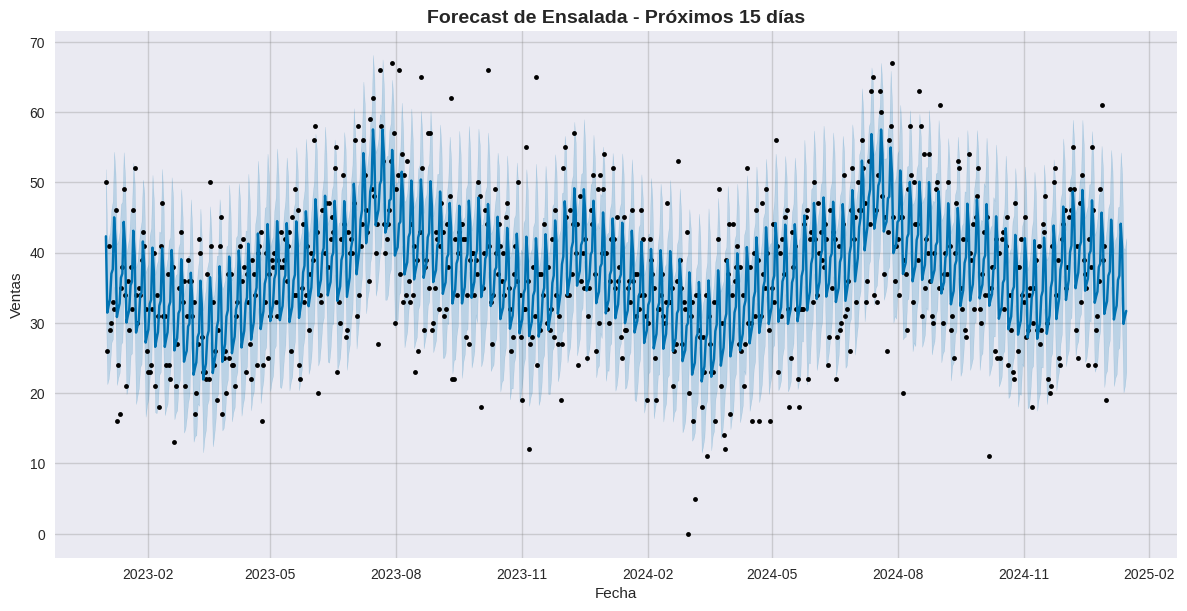

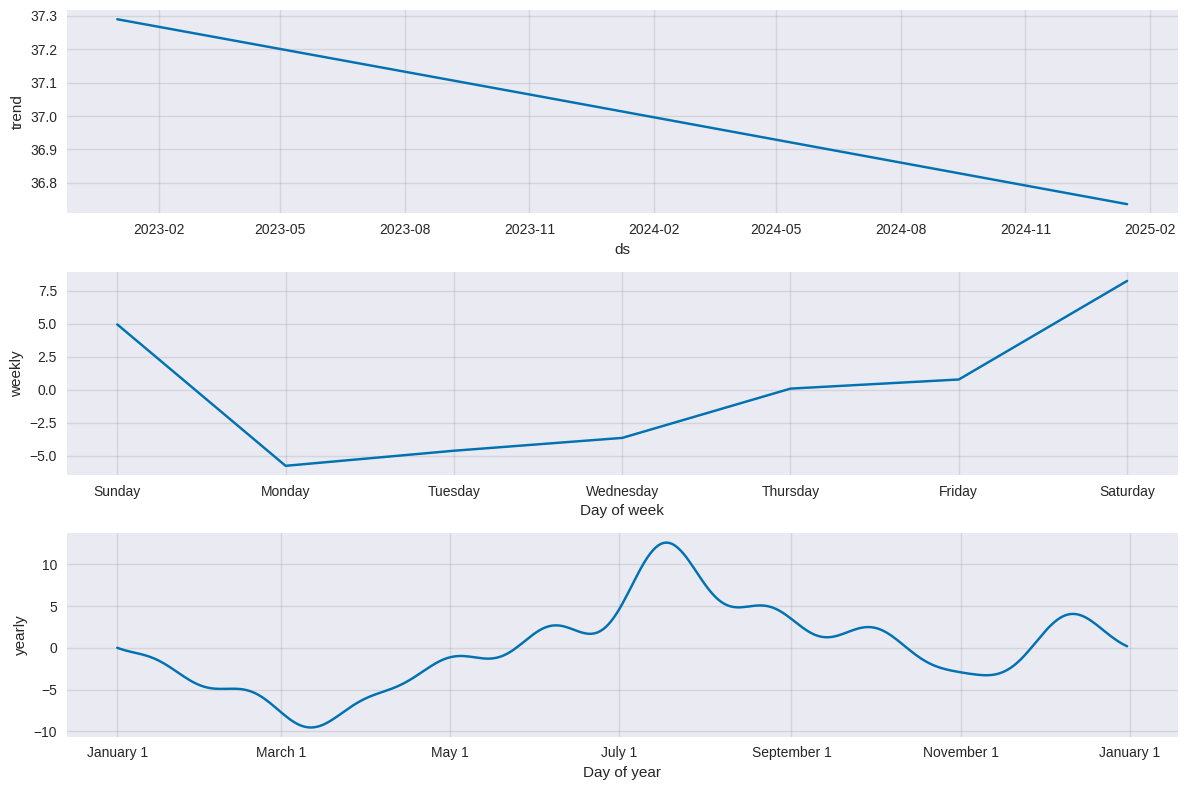

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxo9zbf2x/dnmyv1cr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxo9zbf2x/w9qbqpzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58750', 'data', 'file=/tmp/tmpxo9zbf2x/dnmyv1cr.json', 'init=/tmp/tmpxo9zbf2x/w9qbqpzc.json', 'output', 'file=/tmp/tmpxo9zbf2x/prophet_modelsi9xq57p/prophet_model-20250726165507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:55:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Analizando Sushi...


16:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast para Sushi (próximos 15 días):
  2025-01-01: 42.2 (IC: 29.6 - 54.7)
  2025-01-02: 46.7 (IC: 34.0 - 59.0)
  2025-01-03: 51.0 (IC: 39.0 - 63.0)
  2025-01-04: 59.2 (IC: 47.1 - 71.1)
  2025-01-05: 52.8 (IC: 39.8 - 64.9)
  2025-01-06: 38.6 (IC: 26.1 - 50.6)
  2025-01-07: 44.9 (IC: 33.4 - 57.3)
  2025-01-08: 42.4 (IC: 29.5 - 54.6)
  2025-01-09: 46.9 (IC: 34.0 - 59.6)
  2025-01-10: 51.1 (IC: 38.8 - 63.8)
  2025-01-11: 59.3 (IC: 47.1 - 70.8)
  2025-01-12: 52.7 (IC: 40.6 - 64.4)
  2025-01-13: 38.4 (IC: 26.3 - 50.8)
  2025-01-14: 44.6 (IC: 32.6 - 57.8)
  2025-01-15: 41.9 (IC: 30.1 - 54.3)


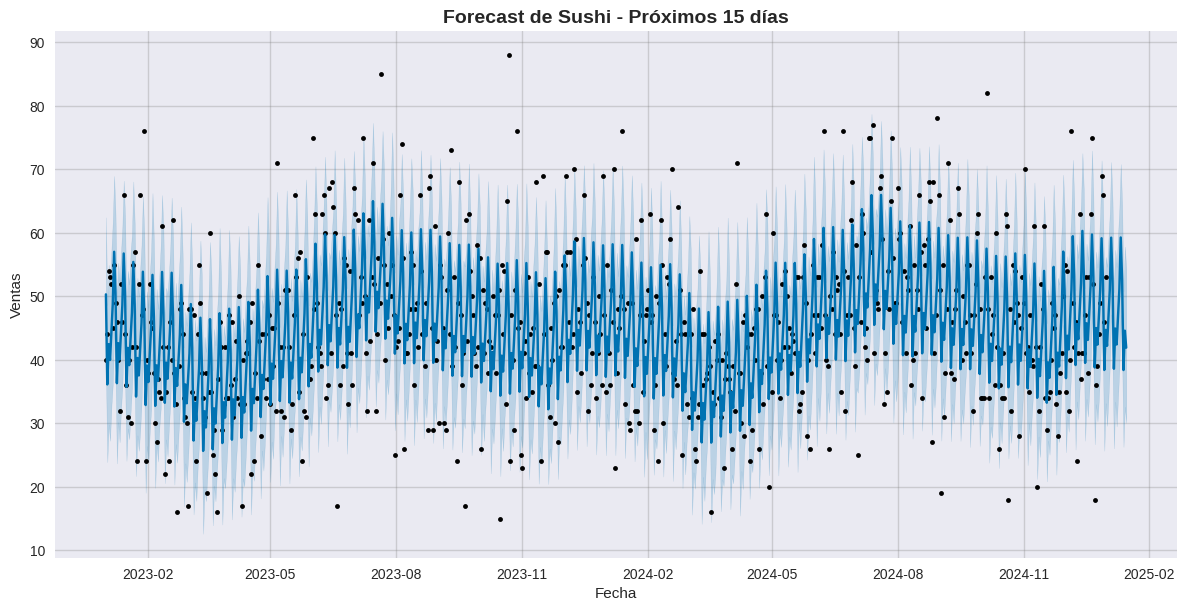

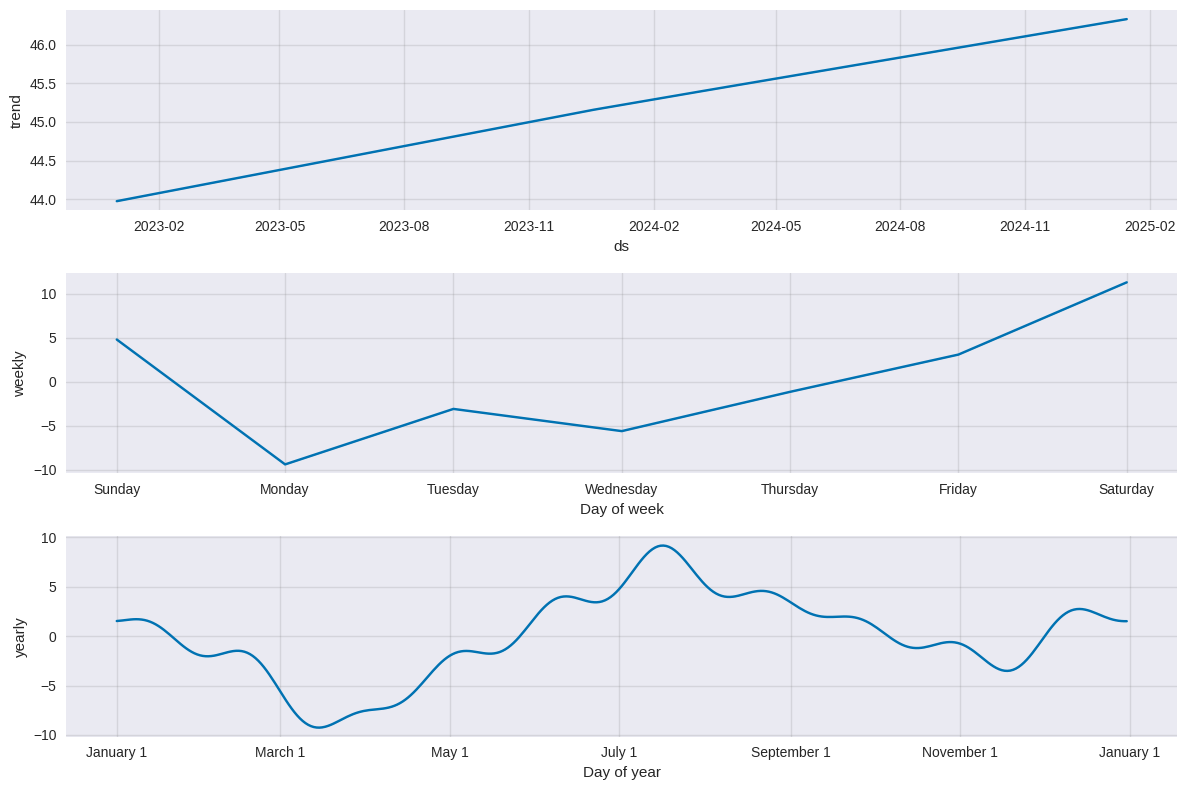


RESUMEN DE FORECASTS - PRÓXIMOS 15 DÍAS
Producto    Ensalada  Hamburguesa  Pizza  Sushi
Fecha                                          
2025-01-01      33.1         50.0   69.8   42.2
2025-01-02      36.7         55.5   74.0   46.7
2025-01-03      37.3         60.3   83.8   51.0
2025-01-04      44.7         71.5   93.8   59.2
2025-01-05      41.3         67.1   87.7   52.8
2025-01-06      30.5         46.3   63.4   38.6
2025-01-07      31.6         51.4   66.3   44.9
2025-01-08      32.4         51.3   66.9   42.4
2025-01-09      36.1         57.0   71.0   46.9
2025-01-10      36.7         62.0   80.5   51.1
2025-01-11      44.1         73.2   90.4   59.3
2025-01-12      40.7         68.8   84.2   52.7
2025-01-13      29.9         47.9   59.8   38.4
2025-01-14      30.9         52.9   62.6   44.6
2025-01-15      31.7         52.6   63.2   41.9

Resultados guardados en 'forecast_15_dias_resultados.csv'

ESTADÍSTICAS DESCRIPTIVAS - DATOS DIARIOS
        Pizza  Hamburguesa  Ensalada   Su

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Intentar importar Prophet, si no está instalada, instalarla
try:
    from prophet import Prophet
    print("Prophet ya está instalada")
except ImportError:
    print("Instalando Prophet...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "prophet"])
    from prophet import Prophet
    print("Prophet instalada correctamente")

# Configuración de estilo para las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_and_prepare_data():
    """Cargar y preparar los datos desde GitHub"""
    # URL del archivo en GitHub
    url = "https://github.com/santiagonajera/Ventas-Diarias/blob/main/Ventas_diarias_restaurante.csv"

    # Convertir URL de GitHub a URL raw
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob', '')

    # Cargar datos desde la URL
    df = pd.read_csv(raw_url)

    # Convertir la columna de fecha a datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Ordenar por fecha
    df = df.sort_values('Fecha').reset_index(drop=True)

    return df

def prepare_data_for_prophet(df, product):
    """Preparar datos para Prophet"""
    # Seleccionar solo las columnas necesarias
    data = df[['Fecha', product]].copy()

    # Renombrar columnas según lo requerido por Prophet
    data = data.rename(columns={'Fecha': 'ds', product: 'y'})

    return data

def forecast_next_15_days(df_prophet, product_name):
    """Generar forecast para los próximos 15 días usando Prophet"""

    # Crear y configurar el modelo Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive'
    )

    # Ajustar el modelo
    model.fit(df_prophet)

    # Crear dataframe para future predictions (próximos 15 días)
    future = model.make_future_dataframe(periods=15)

    # Hacer las predicciones
    forecast = model.predict(future)

    return model, forecast

def plot_prophet_forecast(model, forecast, product_name, df_prophet):
    """Crear gráfica de forecast de Prophet"""
    fig = model.plot(forecast, figsize=(12, 6))
    plt.title(f'Forecast de {product_name} - Próximos 15 días', fontsize=14, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Gráfica de componentes
    fig2 = model.plot_components(forecast, figsize=(12, 8))
    plt.show()

def main():
    try:
        # Cargar y preparar datos
        print("Cargando datos desde GitHub...")
        df = load_and_prepare_data()
        print(f"Datos cargados: {len(df)} registros")
        print(f"Rango de fechas: {df['Fecha'].min()} a {df['Fecha'].max()}")

        # Productos a analizar
        products = ['Pizza', 'Hamburguesa', 'Ensalada', 'Sushi']

        # Diccionario para almacenar resultados
        forecast_results = {}

        # Procesar cada producto
        for product in products:
            print(f"\nAnalizando {product}...")

            # Preparar datos para Prophet
            df_prophet = prepare_data_for_prophet(df, product)

            # Forecast para los próximos 15 días
            model, forecast = forecast_next_15_days(df_prophet, product)

            # Almacenar resultados
            forecast_results[product] = {
                'model': model,
                'forecast': forecast,
                'df_prophet': df_prophet
            }

            # Mostrar resultados numéricos para los próximos 15 días
            print(f"Forecast para {product} (próximos 15 días):")
            future_forecast = forecast.tail(15)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
            future_forecast['ds'] = pd.to_datetime(future_forecast['ds'])
            future_forecast = future_forecast.round(1)

            for idx, row in future_forecast.iterrows():
                print(f"  {row['ds'].strftime('%Y-%m-%d')}: {row['yhat']:.1f} "
                      f"(IC: {row['yhat_lower']:.1f} - {row['yhat_upper']:.1f})")

            # Crear gráficas
            plot_prophet_forecast(model, forecast, product, df_prophet)

        # Crear resumen de forecasts
        print("\n" + "="*80)
        print("RESUMEN DE FORECASTS - PRÓXIMOS 15 DÍAS")
        print("="*80)

        # Crear DataFrame con todos los forecasts futuros
        summary_data = []
        for product in products:
            forecast = forecast_results[product]['forecast']
            future_forecast = forecast.tail(15)[['ds', 'yhat']].copy()
            future_forecast['Producto'] = product
            future_forecast = future_forecast.rename(columns={'ds': 'Fecha', 'yhat': 'Forecast'})
            summary_data.append(future_forecast)

        # Combinar todos los resultados
        summary_df = pd.concat(summary_data, ignore_index=True)
        summary_pivot = summary_df.pivot(index='Fecha', columns='Producto', values='Forecast')
        summary_pivot = summary_pivot.round(1)
        print(summary_pivot)

        # Guardar resultados en CSV
        summary_df.to_csv('forecast_15_dias_resultados.csv', index=False)
        print(f"\nResultados guardados en 'forecast_15_dias_resultados.csv'")

        # Mostrar estadísticas descriptivas
        print("\n" + "="*60)
        print("ESTADÍSTICAS DESCRIPTIVAS - DATOS DIARIOS")
        print("="*60)
        daily_stats = df[products].describe()
        print(daily_stats.round(2))

    except Exception as e:
        print(f"Error: {str(e)}")
        print("Asegúrate de tener conexión a internet y que el archivo esté disponible en la URL proporcionada.")

if __name__ == "__main__":
    main()